In [1]:
import os, glob
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pdb
import scipy
from scipy.optimize import minimize, fmin
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import matplotlib
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['tahoma']
def makeAxesPretty(ax):
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [2]:
# defining variables
expt_tones = np.arange(90,3000,1) #array of possible true tones
log_freq_seq_array = np.arange(0.6,4.7,0.1)
log_freq_percept = np.arange(0.6,4.7,0.1) # array of possible perceptual tones

def extractData(csv_test, csv_data, exptTotalLength, exptLengthWithBreaks):  
    n_tones=3
    n_trials = csv_data.shape[0]-47

    test_columns = list(csv_test.columns)
    test_tones_name = test_columns.index('Name')
    test_tones_col_idx = test_columns.index('Tones')
    test_toneKind_col_idx = test_columns.index('Tonekind')
    df_names = (csv_test.iloc[0:exptTotalLength,test_tones_name]).values
    df_tones = (csv_test.iloc[0:exptTotalLength,test_tones_col_idx]).values
    df_toneKind = (csv_test.iloc[0:exptTotalLength,test_toneKind_col_idx]).values

    tones_array_orig = np.zeros((n_trials,n_tones))
    toneKind_array_orig = np.zeros((n_trials,n_tones))
    tones_array_idxs_keep = []

    for i_wav in range(exptLengthWithBreaks):
        if isinstance(csv_data['Name'][i_wav+46],str):
            tones_array_orig[i_wav,:] = np.array(df_tones[np.where(csv_data['Name'][i_wav+46]
                                                                   ==df_names)[0]][0][1:-1].split(',')).astype(float)  
            toneKind_array_orig[i_wav,:] = np.array(df_toneKind[np.where(csv_data['Name'][i_wav+46]
                                                                          ==df_names)[0]][0][1:-1].split(',')).astype(float)  
            tones_array_idxs_keep += [i_wav]


    exptTones = np.copy(tones_array_orig[tones_array_idxs_keep,:])
    exptToneKind = np.copy(toneKind_array_orig[tones_array_idxs_keep,:])
    exptCorrans = np.copy(csv_data['corrAns'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    exptKeys = np.copy(csv_data['test_resp.keys'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    
    return exptTones, exptToneKind, exptCorrans, exptKeys

def identifyResponseTrials(tonesPlayed,tonesSignalOrDistractor,correctAns,keysPressed,
                           exptTotalLength, printText=0):
    no_response = np.intersect1d(np.where(keysPressed!='h')[0],
                                 np.where(keysPressed!='l')[0])
    #print("Did not respond to: ",no_response)

    """
    Convert keys ['l','h'] to [0,1]
    """

    corrans_num_orig = np.zeros_like(correctAns)
    corrans_num_orig[correctAns == 'h'] = 1

    keys_num_orig = np.zeros_like(keysPressed)
    keys_num_orig[keysPressed == 'h'] = 1

    corrans_num = corrans_num_orig[:exptTotalLength]
    keys_num = keys_num_orig[:exptTotalLength]
    tones_array = tonesPlayed[:exptTotalLength]
    tonesType_array = tonesSignalOrDistractor[:exptTotalLength]

    trial_tones = np.repeat(tones_array,1,axis = 0)
    trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape)) 
    idxs_with_response = np.delete(np.arange(len(trial_tones)),no_response)
    trialTonesResponded = trial_tones[idxs_with_response,:]
    trialBehaviourResponded = trial_behaviour[idxs_with_response]
    corransResponded = corrans_num[idxs_with_response]
    tonesTypeResponded = tonesType_array[idxs_with_response]
    
    """
    Using data to constrain the plow parameter
    """   
    idxHigh = np.arange(len(trialBehaviourResponded))[corransResponded==1]
    idxLow = np.arange(len(trialBehaviourResponded))[corransResponded==0]
    idxToKeep = np.concatenate((idxHigh, np.random.choice(idxLow,size=len(idxLow),replace=False)))
    if printText:
        print(f"Total trials played are {len(trial_tones)}, and total trials responded to are {len(trialTonesResponded)}")
        print("Got correct: ", np.sum(trialBehaviourResponded==corransResponded)/len(trialTonesResponded))
        print("No. of minority category correct: ", np.sum(keys_num*corrans_num)/np.sum(corrans_num))
        print("Majority category accuracy - minority category accuracy",
              -np.sum((1-keys_num)*(1-corrans_num))/np.sum(1-corrans_num)
              +np.sum((keys_num)*(corrans_num))/np.sum(corrans_num))
        print("probability of low given the data is likely to be: ", 1-sum(trial_behaviour[idxToKeep])/len(idxToKeep))
    
    return trialTonesResponded, tonesTypeResponded, corransResponded, trialBehaviourResponded 

def plottingInfluenceFn(tones, behaviour):
    unique_tones = np.unique(tones)

    tone1_prob_behaviour = np.zeros((len(unique_tones),1))
    tone2_prob_behaviour = np.zeros((len(unique_tones),1))
    tone3_prob_behaviour = np.zeros((len(unique_tones),1))
    
    for i_tone in range(len(unique_tones)):
        tone1_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,0]==unique_tones[i_tone]])
        tone2_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,1]==unique_tones[i_tone]])
        tone3_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,2]==unique_tones[i_tone]])
    behaviour = np.concatenate((tone1_prob_behaviour,tone2_prob_behaviour,tone3_prob_behaviour),axis=1)
    return unique_tones, behaviour  


In [3]:
def localEffectNumberOfDistractors(tones,tonesType,corrAns,behaviour):
    
    trialIdxs = np.arange(len(corrAns)-1)
    trialIdxsCategory = np.copy(trialIdxs)
    
    """
    Prev trial has 0 distractors
    """
    zeroDistractorIdx = trialIdxs[np.sum(tonesType[:-1,:]==0,axis=1)==0]
    oneDistractorIdx = trialIdxs[np.sum(tonesType[:-1,:]==0,axis=1)==1]
    twoDistractorIdx = trialIdxs[np.sum(tonesType[:-1,:]==0,axis=1)==2]
    threeDistractorIdx = trialIdxs[np.sum(tonesType[:-1,:]==0,axis=1)==3]
    
    behaviourSucceedingZeroDist = behaviour[zeroDistractorIdx+1]
    corransSucceedingZeroDist = corrAns[zeroDistractorIdx+1]
    behaviourSucceedingOneDist = behaviour[oneDistractorIdx+1]
    corransSucceedingOneDist = corrAns[oneDistractorIdx+1]
    behaviourSucceedingTwoDist = behaviour[twoDistractorIdx+1]
    corransSucceedingTwoDist = corrAns[twoDistractorIdx+1]
    behaviourSucceedingThreeDist = behaviour[threeDistractorIdx+1]
    corransSucceedingThreeDist = corrAns[threeDistractorIdx+1]
    
    accuracySucceedingZeroDist = sum(corransSucceedingZeroDist == behaviourSucceedingZeroDist)/len(corransSucceedingZeroDist)
    accuracySucceedingOneDist = sum(corransSucceedingOneDist == behaviourSucceedingOneDist)/len(corransSucceedingOneDist)
    accuracySucceedingTwoDist = sum(corransSucceedingTwoDist == behaviourSucceedingTwoDist)/len(corransSucceedingTwoDist)
    accuracySucceedingThreeDist = sum(corransSucceedingThreeDist == behaviourSucceedingThreeDist)/len(corransSucceedingThreeDist)
    accuracy = sum(corrAns == behaviour)/len(corrAns)
    
    return ([accuracySucceedingZeroDist, accuracySucceedingOneDist, accuracySucceedingTwoDist,
            accuracySucceedingThreeDist], accuracy)


In [4]:
""" 
Short-term context plots for an individual participant
"""

Test = pd.read_csv('subjectDataForPlots/allTrials_noBias.csv')
Data = pd.read_csv('subjectDataForPlots/noContextData/5f4032479b2b92152488188a_categorization_task_2021-05-19_16h44.41.870.csv');

df_tones, df_toneKind, df_corrans, df_keys = extractData(csv_test=Test, 
                                                        csv_data=Data, 
                                                        exptTotalLength=600, 
                                                        exptLengthWithBreaks=603) 

[trial_tones, trial_tonesType, trial_corrans, trial_behaviour] = identifyResponseTrials(keysPressed = df_keys,
                                                                        correctAns = df_corrans, 
                                                                        tonesPlayed = df_tones, 
                                                                        tonesSignalOrDistractor = df_toneKind,
                                                                        exptTotalLength = 600)

[[accuracySucceedingZeroDist, accuracySucceedingOneDist, 
 accuracySucceedingTwoDist, accuracySucceedingThreeDist], accuracy] = localEffectNumberOfDistractors(tones=trial_tones,
                                                                                          tonesType=trial_tonesType,
                                                                                          corrAns=trial_corrans,
                                                                                          behaviour=trial_behaviour)
print([accuracySucceedingZeroDist, accuracySucceedingOneDist, accuracySucceedingTwoDist,
     accuracySucceedingThreeDist])


[0.8577777777777778, 0.8445378151260504, 0.8173913043478261, 0.9]


[0.79848208 0.7826703  0.76598816 0.74666353] [0.06220186 0.06008031 0.07722936 0.10598028]
Correlation of both categories accuracy with prev number of distractors           n    r         CI95%  p-val  power
spearman  4 -1.0  [-1.0, -1.0]    0.0      1
Overall accuracy 0.7842767470892189


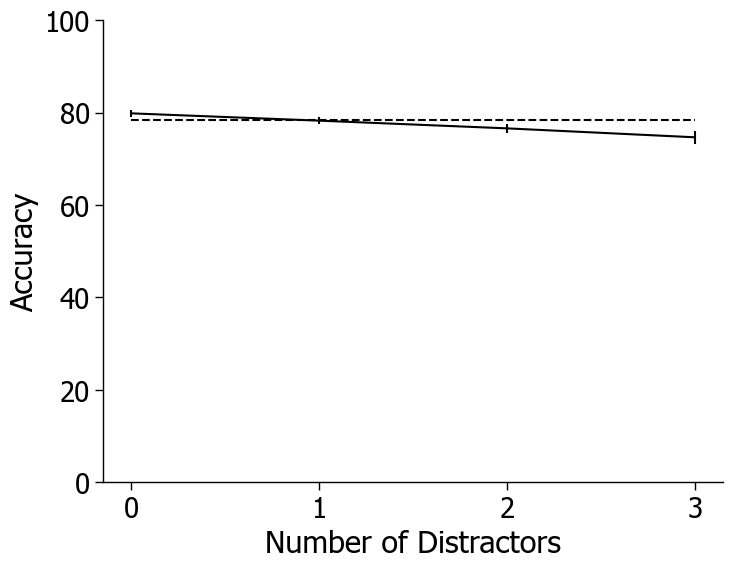

In [5]:
"""
Fig. S7B: Short-term context plots for the population -- accuracy versus number of distractors in the previous trial
"""

Test = pd.read_csv('subjectDataForPlots/allTrials_noBias.csv')
SubjectFiles = os.listdir('subjectDataForPlots/noContextData')
accuracySucceedingDistractors = np.zeros((56,4))
accuracyOverall = np.zeros((56,))
for subjectIdx in range(56): 
    filename = 'subjectDataForPlots/noContextData/'+SubjectFiles[subjectIdx]  
    Data = pd.read_csv(filename);

    df_noTones, df_noToneKind, df_noCorrans, df_noKeys = extractData(csv_test=Test, 
                                                                    csv_data=Data, 
                                                                    exptTotalLength=600, 
                                                                    exptLengthWithBreaks=603) 

    [noTones, noToneTypes, noCorrans, noBehaviour] = identifyResponseTrials(keysPressed = df_noKeys,
                                                                            correctAns = df_noCorrans, 
                                                                            tonesPlayed = df_noTones, 
                                                                            tonesSignalOrDistractor = df_noToneKind,
                                                                            exptTotalLength = 600)  

    (accuracySucceedingDistractors[subjectIdx,:],
     accuracyOverall[subjectIdx])= localEffectNumberOfDistractors(tones=noTones,
                                                                  tonesType=noToneTypes,
                                                                  corrAns=noCorrans,
                                                                  behaviour=noBehaviour)
        
print(np.nanmean(accuracySucceedingDistractors,axis=0), np.nanstd(accuracySucceedingDistractors,axis=0))

fig, ax = plt.subplots(1,1,figsize=(8,6))   
ax.errorbar([0,1,2,3], np.nanmean(accuracySucceedingDistractors,axis=0)*100, 
             np.nanstd(accuracySucceedingDistractors,axis=0)*100/np.sqrt(56),color='k')
ax.plot([0,1,2,3], np.nanmean(accuracyOverall,axis=0)*np.ones(4)*100,'k--')
print("Correlation of both categories accuracy with prev number of distractors", 
      pg.corr(np.arange(4),
              np.nanmean(accuracySucceedingDistractors,axis=0),
              method = 'spearman'))
print("Overall accuracy", np.nanmean(accuracyOverall))
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['0','1','2','3'])
ax.set_ylim(0,100)
ax.tick_params(axis='both',labelsize=20,length=6,width=1)
ax.set_xlabel('Number of Distractors',fontsize=22)
ax.set_ylabel('Accuracy',fontsize=22)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('figures/FromProlific/illustrations/localBiasDueToPrevNumberOfDistractors_allSubjects.pdf',
            bbox_inches='tight',transparent=True)

In [ ]:
"""
Stats for delta parameter for correctness. Delta quantifies the effect of the previous trial.
"""

print("Short-term learning in no context")
print(np.mean(subjectBehaviourAfterCorrectResp[:,13:17],axis=1) - 
      np.mean(subjectBehaviourAfterIncorrectResp[:,13:17],axis=1),
      np.mean(np.mean(subjectBehaviourAfterCorrectResp[:,13:17],axis=1) - 
              np.mean(subjectBehaviourAfterIncorrectResp[:,13:17],axis=1)))

print("Wilcoxon test on short-term learning delta", 
      pg.wilcoxon(np.mean(subjectBehaviourAfterCorrectResp[:,13:17],axis=1) - 
      np.mean(subjectBehaviourAfterIncorrectResp[:,13:17],axis=1)))

shortTermLearning_dict = {"behaviourAfterCorrectTrialNC": subjectBehaviourAfterCorrectResp,
                         "behaviourAfterIncorrectTrialNC": subjectBehaviourAfterIncorrectResp}

#scipy.io.savemat("shortTermLearning_effectOfCorrectnessOnBehavior_HighCategory.mat", shortTermLearning_dict)

In [ ]:
plt.hist(np.mean(subjectBehaviourAfterCorrectResp[:,13:17],axis=1) - 
      np.mean(subjectBehaviourAfterIncorrectResp[:,13:17],axis=1))

expt_freq_seq = np.arange(90,3000,1)
expt_log_freq_seq_array = np.arange(np.log10(expt_freq_seq[0]), np.log10(expt_freq_seq[-1]), 
                                    np.log10(1003/1000)*40)

print(10**(np.mean(expt_log_freq_seq_array[13:17])))